In [1]:
import numpy as np
import os
import seaborn as sns
from PIL import Image
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import random
import matplotlib.pyplot as plt
import keras
import scipy
from keras import models, layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet_v2 import ResNet50V2,ResNet101V2
from keras.applications.inception_v3 import InceptionV3
import albumentations as A

In [2]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount = True)
# !zip -r file.zip '/kaggle/working'

## Data Sourcing

In [3]:
labels = ['Normal/images','COVID/images']
img_size = 299
count = []

def get_data(data_dir):
    data = [] 
    for label in labels: 
        counter = 0
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img),cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
                counter = counter + 1
            except Exception as e:
                print(e)
        count.append(counter)
    return np.array(data)

# path = r'/content/drive/MyDrive/COVID-19_Radiography_Dataset/' # Google Colab Path
path = r'C:/Users/gampl/OneDrive/Desktop/notebooks/COVID-19_Radiography_Dataset' # Local Path
# path = r"/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset" # Kaggle Path
data = get_data(path)

C:\Users\gampl\AppData\Local\Temp\ipykernel_17532\2573449976.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


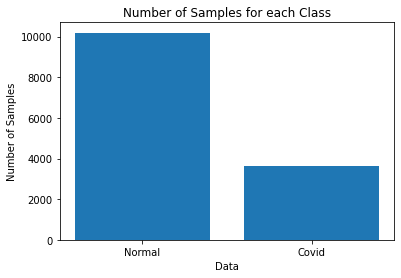

In [4]:
plt.bar(["Normal","Covid"], count)
plt.xlabel("Data")
plt.ylabel("Number of Samples")
plt.title("Number of Samples for each Class")
plt.show()

## Splitting Data

In [5]:
x_data = data[:,0:1]
y_data = data[:,1:2]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
x_train = x_train.squeeze()
x_test = x_test.squeeze()
y_train = y_train.squeeze()
y_test = y_test.squeeze()
x_train = np.array([np.array(val) for val in x_train])
y_train = np.array([np.array(val) for val in y_train])
x_test = np.array([np.array(val) for val in x_test])
y_test = np.array([np.array(val) for val in y_test])

print("Size of training dataset before Data Augmentation",len(x_train))

Size of training dataset before Data Augmentation 9665


## Data Augmentation

In [6]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)
    
## Albumentations transformation pipeline
    
transform = A.Compose(
    [
     A.RandomRotate90(),
     A.HorizontalFlip(p=0.5),
     A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2,
                        rotate_limit=20, p=.75),
     A.Blur(blur_limit=3),
    ])

augmented_data_x = []
augmented_data_y = []
sample_original = []
sample_transformed = []

counter = 0
for j in range(2):
    for i in range(count[0],len(x_data)):
        augmented_image = transform(image=x_data[i][0])['image']
        augmented_data_x.append(augmented_image)
        augmented_data_y.append(y_data[i])
        if(j==1):
            if(counter<5):
                sample_original.append(x_data[i][0])
                sample_transformed.append(augmented_image)
                counter += 1
                
        
x_train = np.append(x_train,augmented_data_x,axis=0)
y_train = np.append(y_train,augmented_data_y)
x_train = x_train.squeeze()
y_train = y_train.squeeze()
x_train = np.array([np.array(val) for val in x_train])
y_train = np.array([np.array(val) for val in y_train])

## All the augmented data was appended sequentially to the training data
## Hence we want to shuffle the training data one more time

indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)

x_train = x_train[indices]
y_train = y_train[indices]

print("Size of training dataset before Data Augmentation",len(x_train))

Size of training dataset before Data Augmentation 16897


## Albumentations Transformation Samples

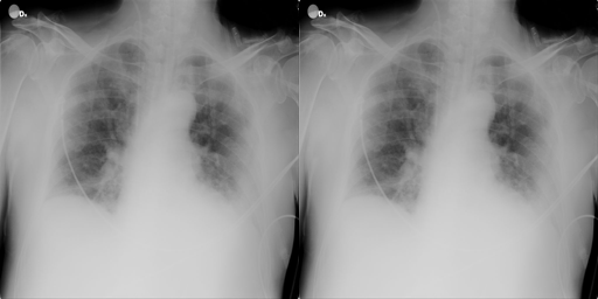

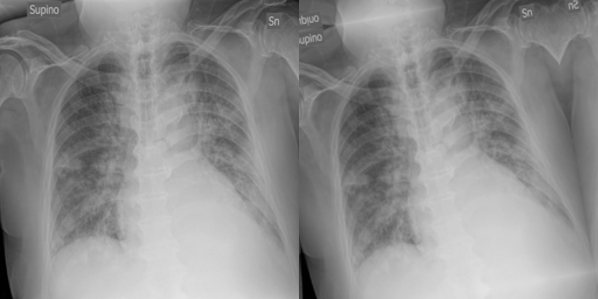

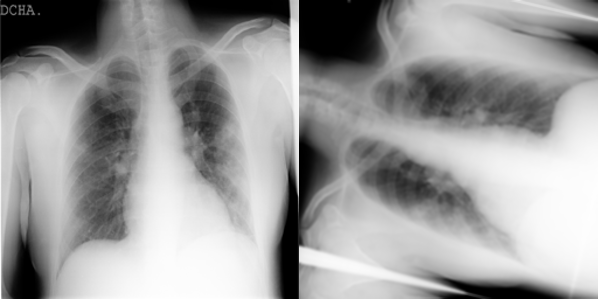

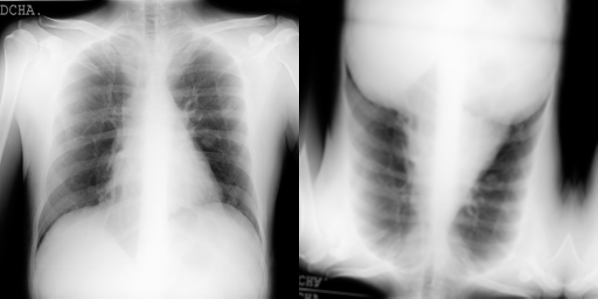

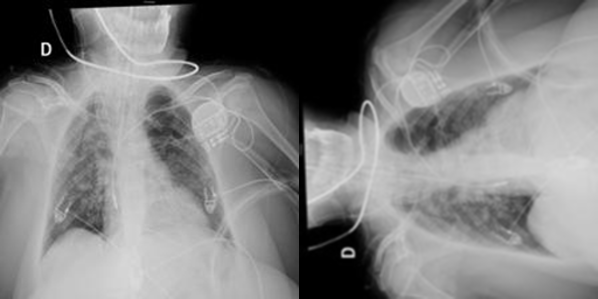

In [16]:
for i in range(len(sample_original)):
    img = Image.fromarray(sample_original[i])
    img.save(str(i)+".png")
    transformed_image = Image.fromarray(sample_transformed[i])
    transformed_image.save(str(i)+"_1.png")
    dst = Image.new('RGB', (img.width + transformed_image.width , transformed_image.height))
    dst.paste(img, (0, 0))
    dst.paste(transformed_image, (img.width, 0))
    display(dst)

In [9]:
print("Size of training dataset after Data Augmentation: ",len(x_train))

Size of training dataset after Data Augmentation:  16897


## VGG16 Model

In [8]:
conv_base = VGG16(weights=None, include_top=False,input_shape = (299,299,1),classes = 2)
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
opt = tf.keras.optimizers.SGD()

## Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(x_train,y_train, epochs=20, batch_size=20)
loss,accuracy = model.evaluate(x_test, y_test)
print("Model accuracy: %.2f"% (accuracy*100))
model.save('VGG16_model')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14713536  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 1024)              42468352  
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 57,182,913
Trainable params: 57,182,913
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
845/845 [==============================] - 319s 363ms/step - loss: 0.4161 - accuracy: 0.7953
Epoch 2/20
845/845 [==============================] - 338s 400ms/step - 

INFO:tensorflow:Assets written to: VGG16_model\assets


INFO:tensorflow:Assets written to: VGG16_model\assets


## VGG19 Model

In [7]:
conv_base = VGG19(weights=None, include_top=False,input_shape = (299,299,1),classes = 2)
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
opt = tf.keras.optimizers.SGD()

## Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(x_train,y_train, epochs=20, batch_size=20)
loss,accuracy = model.evaluate(x_test, y_test)
print("Model accuracy: %.2f"% (accuracy*100))
model.save('VGG19_model')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 9, 9, 512)         20023232  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 1024)              42468352  
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 62,492,609
Trainable params: 62,492,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
845/845 [==============================] - 373s 428ms/step - loss: 0.4548 - accuracy: 0.7743
Epoch 2/20
845/845 [==============================] - 381s 451ms/step - 

INFO:tensorflow:Assets written to: VGG19_model\assets


INFO:tensorflow:Assets written to: VGG19_model\assets


## ResNet50 Model

In [9]:
conv_base = ResNet50V2(weights=None, include_top=False,input_shape = (299,299,1),classes = 2,classifier_activation='softmax')
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
opt = tf.keras.optimizers.SGD()

## Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(x_train,y_train, epochs=20, batch_size=20)
loss,accuracy = model.evaluate(x_test, y_test)
print("Model accuracy: %.2f"% (accuracy*100))
model.save('ResNet50_model')

Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmpp0_6q9in.PNG'
2022-09-24 20:31:17.918101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 20:31:18.036277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 20:31:18.037223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 10, 10, 2048)      23558528  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              209716224 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 233,275,777
Trainable params: 233,230,337
Non-trainable params: 45,440
_________________________________________________________________


2022-09-24 20:31:21.972504: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1510608697 exceeds 10% of free system memory.
2022-09-24 20:31:23.635533: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1510608697 exceeds 10% of free system memory.
2022-09-24 20:31:24.917592: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-09-24 20:31:30.094345: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


845/845 [==============================] - 174s 191ms/step - loss: 0.3137 - accuracy: 0.8751
Epoch 2/20
845/845 [==============================] - 161s 190ms/step - loss: 0.1709 - accuracy: 0.9306
Epoch 3/20
845/845 [==============================] - 161s 190ms/step - loss: 0.1188 - accuracy: 0.9525
Epoch 4/20
845/845 [==============================] - 160s 190ms/step - loss: 0.0850 - accuracy: 0.9665
Epoch 5/20
845/845 [==============================] - 161s 190ms/step - loss: 0.0583 - accuracy: 0.9779
Epoch 6/20
845/845 [==============================] - 160s 190ms/step - loss: 0.0363 - accuracy: 0.9865
Epoch 7/20
845/845 [==============================] - 160s 190ms/step - loss: 0.0293 - accuracy: 0.9894
Epoch 8/20
845/845 [==============================] - 160s 190ms/step - loss: 0.0197 - accuracy: 0.9934
Epoch 9/20
845/845 [==============================] - 160s 190ms/step - loss: 0.0134 - accuracy: 0.9956
Epoch 10/20
845/845 [==============================] - 160s 190ms/step - lo

2022-09-24 21:25:38.940191: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-09-24 21:25:54.551069: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 838860800 exceeds 10% of free system memory.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## ResNet101 Model

In [11]:
conv_base = ResNet101V2(weights=None, include_top=False,input_shape = (299,299,1),classes = 2,classifier_activation='softmax')
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
opt = tf.keras.optimizers.SGD()

## Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(x_train,y_train, epochs=20, batch_size=20)
loss,accuracy = model.evaluate(x_test, y_test)
print("Model accuracy: %.2f"% (accuracy*100))
model.save('ResNet101_model')

Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmplj8785hm.PNG'
2022-09-25 14:51:06.749349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-25 14:51:06.857766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-25 14:51:06.858713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 10, 10, 2048)      42620288  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              209716224 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 252,337,537
Trainable params: 252,239,873
Non-trainable params: 97,664
_________________________________________________________________


2022-09-25 14:51:13.066226: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1510608697 exceeds 10% of free system memory.
2022-09-25 14:51:14.874082: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1510608697 exceeds 10% of free system memory.
2022-09-25 14:51:16.208460: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-09-25 14:51:26.275832: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


845/845 [==============================] - 296s 330ms/step - loss: 0.3229 - accuracy: 0.8678
Epoch 2/20
845/845 [==============================] - 278s 329ms/step - loss: 0.1876 - accuracy: 0.9212
Epoch 3/20
845/845 [==============================] - 278s 328ms/step - loss: 0.1380 - accuracy: 0.9433
Epoch 4/20
845/845 [==============================] - 277s 328ms/step - loss: 0.1026 - accuracy: 0.9592
Epoch 5/20
845/845 [==============================] - 277s 328ms/step - loss: 0.0803 - accuracy: 0.9679
Epoch 6/20
845/845 [==============================] - 277s 328ms/step - loss: 0.0625 - accuracy: 0.9765
Epoch 7/20
845/845 [==============================] - 277s 328ms/step - loss: 0.0489 - accuracy: 0.9812
Epoch 8/20
845/845 [==============================] - 277s 328ms/step - loss: 0.0394 - accuracy: 0.9857
Epoch 9/20
845/845 [==============================] - 277s 328ms/step - loss: 0.0319 - accuracy: 0.9881
Epoch 10/20
845/845 [==============================] - 277s 328ms/step - lo

2022-09-25 16:25:54.292626: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-09-25 16:26:30.288953: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 838860800 exceeds 10% of free system memory.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## InceptionV3 Model

In [9]:
conv_base = InceptionV3(weights=None, include_top=False,input_shape = (299,299,1),classes = 2,classifier_activation='softmax')
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
opt = tf.keras.optimizers.SGD()

## Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(x_train,y_train, epochs=20, batch_size=20)
loss,accuracy = model.evaluate(x_test, y_test)
print("Model accuracy: %.2f"% (accuracy*100))
model.save('InceptionV3_model')

Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmpt8m0hygw.PNG'
2022-09-25 16:35:47.590505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-25 16:35:47.702369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-25 16:35:47.703278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802208  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              134218752 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 156,021,985
Trainable params: 155,987,553
Non-trainable params: 34,432
_________________________________________________________________


2022-09-25 16:35:52.640458: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1510608697 exceeds 10% of free system memory.
2022-09-25 16:35:54.317600: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1510608697 exceeds 10% of free system memory.
2022-09-25 16:35:55.652829: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-09-25 16:36:01.827391: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


845/845 [==============================] - 159s 172ms/step - loss: 0.3370 - accuracy: 0.8595
Epoch 2/20
845/845 [==============================] - 144s 171ms/step - loss: 0.1727 - accuracy: 0.9264
Epoch 3/20
845/845 [==============================] - 144s 171ms/step - loss: 0.1398 - accuracy: 0.9438
Epoch 4/20
845/845 [==============================] - 144s 171ms/step - loss: 0.1153 - accuracy: 0.9545
Epoch 5/20
845/845 [==============================] - 144s 171ms/step - loss: 0.0979 - accuracy: 0.9595
Epoch 6/20
845/845 [==============================] - 144s 170ms/step - loss: 0.0881 - accuracy: 0.9659
Epoch 7/20
845/845 [==============================] - 144s 170ms/step - loss: 0.0776 - accuracy: 0.9702
Epoch 8/20
845/845 [==============================] - 144s 170ms/step - loss: 0.0658 - accuracy: 0.9751
Epoch 9/20
845/845 [==============================] - 144s 170ms/step - loss: 0.0599 - accuracy: 0.9768
Epoch 10/20
845/845 [==============================] - 144s 170ms/step - lo

2022-09-25 17:24:38.702105: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-09-25 17:25:04.456170: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 536870912 exceeds 10% of free system memory.


## Model Loading

In [6]:
# Select which models to be included in the ensemble

VGG16_model = 0
VGG19_model = 1
ResNet50_model = 0
ResNet101_model = 1
InceptionV3_model = 1

models = []
model_names = []

if(VGG16_model):
    VGG16_model = keras.models.load_model('Model weights\VGG16_model')
    models.append(VGG16_model)
    model_names.append("VGG16 Model")
    
if(VGG19_model):
    VGG19_model = keras.models.load_model('Model weights\VGG19_model')
    models.append(VGG19_model)
    model_names.append("VGG19 Model")
    
if(ResNet50_model):
    ResNet50_model = keras.models.load_model('Model weights\ResNet50_model')
    models.append(ResNet50_model)
    model_names.append("ResNet50 Model")
    
if(ResNet101_model):
    ResNet101_model = keras.models.load_model('Model weights\ResNet101_model') 
    models.append(ResNet101_model)
    model_names.append("ResNet101 Model")
    
if(InceptionV3_model):
    InceptionV3_model = keras.models.load_model('Model weights\InceptionV3_model')
    models.append(InceptionV3_model)
    model_names.append("InceptionV3 Model")

## Building the ensemble

130/130 [==============================] - 12s 78ms/step

VGG19 Model 

Accuracy 99.28 %
Precision: 98.84 %
Recall: 99.26 %
F1 Score 99.05 % 



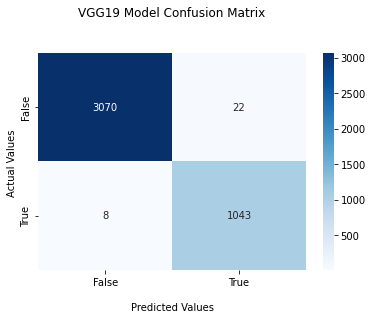

ResNet101 Model 

Accuracy 99.28 %
Precision: 98.87 %
Recall: 99.23 %
F1 Score 99.05 % 



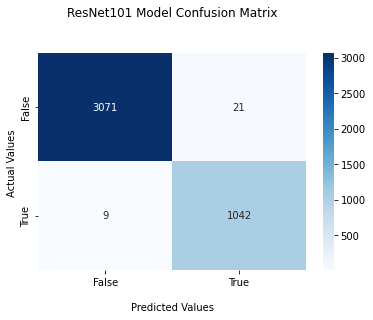

InceptionV3 Model 

Accuracy 98.53 %
Precision: 97.53 %
Recall: 98.67 %
F1 Score 98.08 % 



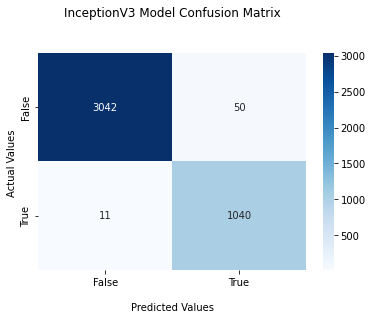

Ensemble Model

Accuracy : 99.69 %
Precision: 99.45 %
Recall: 99.73 %
F1 Score 99.59 %


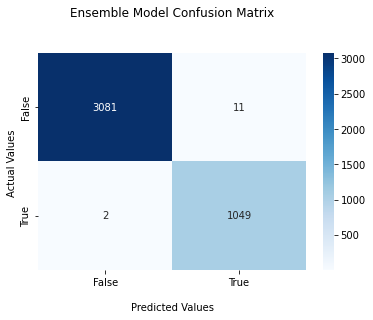

In [7]:
predictions = []

def createEnsemble(models,technique="average",size=100):
    global predictions
    num_models = len(models)
    for model in models:
        predictions.append(model.predict(x_test[0:size]))
        
    temp = []
    final_predictions = []
    for i in range(len(predictions[0])):
        temp = []
        for j in range(num_models):
            temp.append(predictions[j][i])
        if(technique == "mode"):
            new_list = [np.round(item) for item in temp]
            final_predictions.append(scipy.stats.mode(new_list)[0])
        else:
            final_predictions.append(sum(temp)/num_models)
            final_predictions = [np.round(item) for item in final_predictions]
    final_predictions = [item for sublist in final_predictions for item in sublist]
    predictions = [np.round(item) for item in predictions]

            
    return final_predictions

def evaluate(predictions):
    score = 0
    for i in range(len(predictions)):
        if(predictions[i] == y_test[i]):
            score += 1
    return score/len(predictions)

# 2 techniques for the ensemble 
# "mode" selects the most common prediction amongst the model predictions
# "average" calculates the average of all the model predictions
    
mode = "mode"
size = len(x_test)

ensemble_predictions = createEnsemble(models,mode,size)
print()

for i in range(len(predictions)):
    print(model_names[i],"\n\nAccuracy",round(evaluate(predictions[i])*100,2),"%")
    print("Precision:",round(100*precision_score(y_test[0:size], predictions[i] , average="macro"),2),"%")
    print("Recall:",round(100*recall_score(y_test[0:size], predictions[i] , average="macro"),2),"%")
    print("F1 Score",round(100*f1_score(y_test[0:size], predictions[i] , average="macro",),2),"%","\n")
    cf_matrix = confusion_matrix(y_test[0:size], predictions[i])
    
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')

    ax.set_title(model_names[i]+" Confusion Matrix\n\n");
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    plt.show()
    
ensemble_accuracy = evaluate(ensemble_predictions)
print("Ensemble Model\n\nAccuracy :", round(ensemble_accuracy*100,2),"%")  
print("Precision:",round(100*precision_score(y_test[0:size], ensemble_predictions , average="macro"),2),"%")
print("Recall:",round(100*recall_score(y_test[0:size], ensemble_predictions , average="macro"),2),"%")
print("F1 Score",round(100*f1_score(y_test[0:size], ensemble_predictions , average="macro"),2),"%")

cf_matrix = confusion_matrix(y_test[0:size], ensemble_predictions)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')

ax.set_title("Ensemble Model Confusion Matrix\n\n");
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()